<a href="https://colab.research.google.com/github/csharpshooter/EVA/blob/master/A12/A12-A/A12-A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Mon May 18 22:47:48 2020


In [2]:
from src.dataset.monocularhelper import MonocularHelper
from src.imports import *
import torch.optim.lr_scheduler
import os
from src.train.torchvision import collate_fn, train_one_epoch, warmup_lr_scheduler, MetricLogger, SmoothedValue

%config IPCompleter.greedy=True
%reload_ext autoreload

In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)
    
printgpuinfo()

Mon May 18 22:47:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   77C    P2    36W /  N/A |    877MiB /  8117MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    ram_gb_avail = virtual_memory().available / 1e9
    ram_gb_used = virtual_memory().active / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    print('Your runtime has {:.1f} gigabytes of free RAM\n'.format(ram_gb_avail))
    print('Your runtime has {:.1f} gigabytes of used RAM\n'.format(ram_gb_used))    
showsysteminfo()

Your runtime has 16.7 gigabytes of available RAM

Your runtime has 10.9 gigabytes of free RAM

Your runtime has 6.9 gigabytes of used RAM



In [6]:
import torch
print(torch.__version__)

1.4.0


In [7]:
helper = MonocularHelper()
final_output = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/OverLayedImages'
final_output_mask = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/OverLayedMask'
final_output_dm = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/OverLayedDepthMasks'
bg_path = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/Background'

# final_output = r'/home/abhijit/EVARepo/MonocularDS/OverLayedImages'
# final_output_mask = r'/home/abhijit/EVARepo/MonocularDS/OverLayedMask'
# final_output_dm = r'/home/abhijit/EVARepo/MonocularDS/OverLayedDepthMasks'
# bg_path = r'/home/abhijit/EVARepo/MonocularDS/Background'

train_data, train_label, test_data, test_label = helper.get_train_test_data(masks_folder=final_output_mask,
                                                                            images_folder=final_output,
                                                                            depth_masks_folder=final_output_dm,
                                                                            no_of_batches=40,
                                                                            total_images_count=400000,
                                                                            bg_folder=bg_path)

100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


In [8]:
print(len(train_label))
print(len(test_label))

batch_size = 16

train_transforms, test_transforms = preprochelper.PreprocHelper.getpytorchtransforms(image_net_mean, image_net_std)
ds = dst.Dataset()

train_dataset = ds.get_monocular_train_dataset(train_image_data=train_data, train_image_labels=train_label,
                                               train_transforms=train_transforms)

test_dataset = ds.get_monocular_test_dataset(test_image_labels=test_label, test_image_data=test_data,
                                             test_transforms=test_transforms)

torch.manual_seed(1)

dataloader = dl.Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

280000
120000
CUDA Available? True
16


cuda


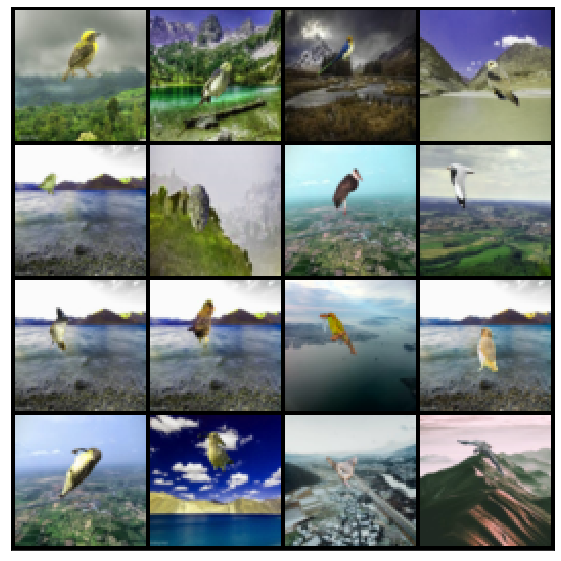

MonocularModel(
  (inputblock): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
    (1): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


In [9]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")

cnn_model, device = utils.Utils.createMonocularModel()
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.01, momentum=0.9, weight_decay=1e-5)

# last_epoch = 1

# if os.path.exists("savedmodels/checkpoint1.pt"):
#     checkpoint, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc \
#         , test_losses, lr_data, class_correct, class_total = utils.Utils.loadmodel("savedmodels/checkpoint1.pt")
#     cnn_model.load_state_dict(model_state_dict)
#     # optimizer.load_state_dict(optimizer_state_dict)
#     last_epoch = last_epoch + checkpoint['epoch']

# cnn_model = torchvision.models.resnet18(pretrained=False, num_classes=2).cuda(device)


sample = next(iter(train_loader))

imgs = sample[0][0]

# grid_tensor = torchvision.utils.make_grid(imgs, 2)
# grid_image = grid_tensor.permute(1, 2, 0)

utils.Utils.show(imgs, nrow=4)

train_model = train.TrainModel()
print(cnn_model)
# optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.01, momentum=0.9, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)

lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 20

  0%|          | 0/17500 [00:00<?, ?it/s]

EPOCH: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/280000 (0%)]	Loss: 0.168679
IOU : 0.0533905029296875


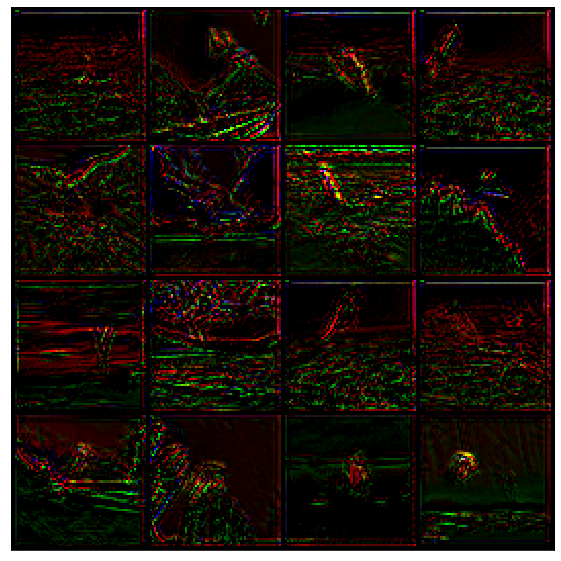

  0%|          | 9/17500 [00:00<1:57:23,  2.48it/s]

IOU : 0.0533905029296875


  0%|          | 54/17500 [00:03<16:06, 18.05it/s]  

Train Epoch: 1 [200/280000 (0%)]	Loss: 0.029273
IOU : 0.051513671875


  1%|          | 99/17500 [00:05<15:54, 18.23it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [400/280000 (1%)]	Loss: 0.026842
IOU : 0.053436279296875


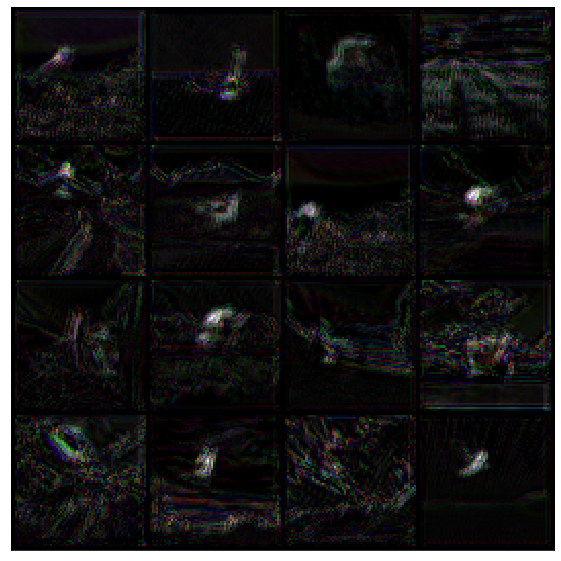

  1%|          | 110/17500 [00:05<20:00, 14.48it/s]

IOU : 0.053436279296875


  1%|          | 151/17500 [00:09<52:30,  5.51it/s]

Train Epoch: 1 [600/280000 (1%)]	Loss: 0.019421
IOU : 0.04779052734375


  1%|          | 199/17500 [00:46<6:52:51,  1.43s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [800/280000 (1%)]	Loss: 0.016928
IOU : 0.0454864501953125


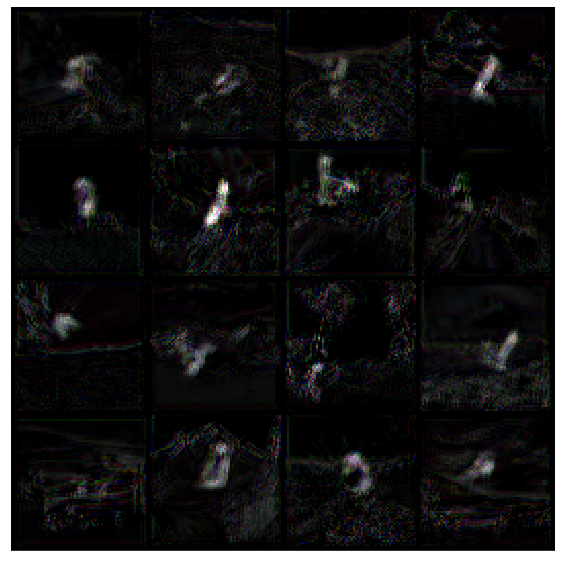

  1%|          | 201/17500 [00:46<4:59:11,  1.04s/it]

IOU : 0.0454864501953125


  1%|          | 218/17500 [00:59<5:17:30,  1.10s/it]

KeyboardInterrupt: 

In [10]:
for epoch in range(1, epochs):
    print("EPOCH:", epoch)
    
    pred = train_model.train_Monocular(cnn_model, device, train_loader, optimizer, 1)
    train_model.test_Monocular(cnn_model, device, test_loader, class_correct, class_total, epoch, lr_data)
    
    from src.utils.utils import Utils
    Utils.show(pred.detach().cpu(), nrow=4)
    
    scheduler.step()

# train_losses, train_acc = train_model.gettraindata()
# test_losses, test_acc = train_model.gettestdata()
# utils.Utils.savemodel(model=cnn_model, epoch=epochs, path="savedmodels/finalmodelwithdata.pt",
#                       optimizer_state_dict=optimizer.state_dict
#                       , train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
#                       test_losses=test_losses, lr_data=lr_data, class_correct=class_correct, class_total=class_total)

In [ ]:
# train_losses, train_acc = train_model.gettraindata()
# test_losses, test_acc = train_model.gettestdata()
# utils.Utils.savemodel(model=cnn_model, epoch=epochs, path="savedmodels/checkpoint12.pt",
#                       optimizer_state_dict=optimizer.state_dict
#                       , train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
#                       test_losses=test_losses, lr_data=lr_data, class_correct=class_correct, class_total=class_total)